In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [4]:
### Read data

DATA_FOLDER = './data/'

df_train = pd.read_csv(os.path.join(DATA_FOLDER, 'train_ver2.csv'))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
df_train.shape

(142762, 48)

In [19]:
### Downsample the dataframe since its too large
unique_ids = pd.Series(df_train["ncodpers"].unique())
limit_people = 10000 # Limit to 100k people
sample_ids = unique_ids.sample(n=limit_people)
df_train = df_train[df_train.ncodpers.isin(sample_ids)]

In [11]:
### Seperate last month from the training data
df_train['fecha_dato'] = pd.to_datetime(df_train['fecha_dato'],format = "%Y-%m-%d")
df_train['fecha_alta'] = pd.to_datetime(df_train['fecha_alta'],format = "%Y-%m-%d")

# Basic Data Cleaning


In [12]:
# Whether containing null value
df_train.isnull().any()

fecha_dato               False
ncodpers                 False
ind_empleado              True
pais_residencia           True
sexo                      True
age                      False
fecha_alta                True
ind_nuevo                 True
antiguedad               False
indrel                    True
ult_fec_cli_1t            True
indrel_1mes               True
tiprel_1mes               True
indresi                   True
indext                    True
conyuemp                  True
canal_entrada             True
indfall                   True
tipodom                   True
cod_prov                  True
nomprov                   True
ind_actividad_cliente     True
renta                     True
segmento                  True
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop_fin_ult1        False
ind_ctpp

In [56]:
# ind_nuevo --> Whether customer is new or not
# This can be inferred from how many months of history customer have

print ("The total NaN values are:", df_train["ind_nuevo"].isnull().sum())
months_active = df_train.loc[df_train["ind_nuevo"].isnull(),:].groupby(
    "ncodpers", sort=False).size()
print("The maximum number of records for these customers having are:",
      months_active.max())

The total NaN values are: 288
The maximum number of records for these customers having are: 6


In [59]:
# Since the maximum number of records are 6, consider those are new customer
df_train.loc[df_train["ind_nuevo"].isnull(), "ind_nuevo"] = 1

In [66]:
# Column antiguedad
df_train.antiguedad = pd.to_numeric(df_train.antiguedad, errors = 'coerce')
df_train.loc[df_train['antiguedad'].isnull(),'angiguedad'] = df_train.antiguedad.min()
df_train.loc[df_train['antiguedad']<0,'antiguedad'] = 0


In [75]:
# For joining the company date, put median 
dates = df_train['fecha_alta'].sort_values().reset_index()

In [72]:
median_date = int(np.median(dates.index.values))
df_train.loc[df_train.fecha_alta.isnull(),'fecha_alta'] = median_date

In [76]:
df_train.fecha_alta.describe()

count                  142762
unique                   3733
top       2014-10-03 00:00:00
freq                      670
Name: fecha_alta, dtype: object

In [80]:
# indrel --> Put in common type
df_train.indrel.value_counts()
df_train.loc[df_train.indrel.isnull(),"indrel"] = 1

In [82]:
# For tipodom and cod_prov, it is already indicated by column nomprov, so drop them
df_train.drop(['tipodom','cod_prov'], axis = 1, inplace = True)

In [84]:
# nomprov --> Since its text figure, fill in UNKNOWN
df_train.loc[df_train.nomprov.isnull(),"nomprov"] = 'UNKNOWN'

In [95]:
# renta --> Fill in with the median for the respective province
incomes = df_train.loc[df_train.renta.notnull(),:].groupby('nomprov').agg(
{"renta":{"MedianIncome":median}})
incomes.sort_values(by=('renta','MedianIncome'),inplace=True)

In [97]:
incomes.reset_index(inplace = True)

In [101]:
incomes.nomprov = incomes.nomprov.astype("category", categories = [
    i for i in df_train.nomprov.unique()], ordered= False)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


([<matplotlib.axis.YTick at 0x123c65358>,
 <a list of 5 Text yticklabel objects>)

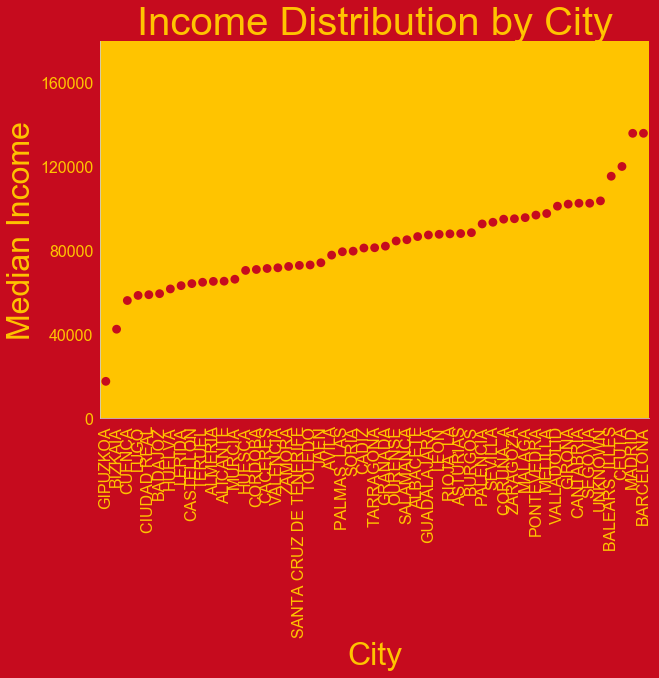

In [105]:
with sns.axes_style({
    "axes.facecolor":"#ffc400",
    "axes.grid":False,
    "figure.facecolor":"#c60b1e"
}):
    h = sns.factorplot(
    data = incomes,
    x = 'nomprov',
    y = ('renta','MedianIncome'),
    order = (i for i in incomes.nomprov),
    size = 6,
    aspect = 1.5,
    scale = 1.0,
    color = '#c60b1e',
    linestyles = 'None'
    )
    
plt.xticks(rotation = 90)
plt.tick_params(labelsize=16,labelcolor="#ffc400")#
plt.ylabel("Median Income",size=32,color="#ffc400")
plt.xlabel("City",size=32,color="#ffc400")
plt.title("Income Distribution by City",size=40,color="#ffc400")
plt.ylim(0,180000)
plt.yticks(range(0,180000,40000))

In [106]:
# Obtain the median value of each province
grouped = df_train.groupby('nomprov').agg({"renta":
                                          lambda x: 
                                           x.median(skipna=True)}).reset_index()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1019: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [143]:
# Append the column of median income for each colomn
new_incomes = pd.merge(df_train, grouped, how = 'inner', on = 'nomprov').loc[:,["nomprov","renta_y"]]
new_incomes = new_incomes.rename(columns={'renta_y':'renta'}).sort_values("nomprov")
df_train.sort_values('nomprov', inplace = True)
#df_train = df_train.reset_index()
new_incomes = new_incomes.reset_index()

ValueError: cannot insert level_0, already exists

In [145]:
# Fill in the column with median value for each entry
df_train.loc[df_train.renta.isnull(),"renta"] = new_incomes.loc[df_train.renta.isnull(),"renta"].reset_index()
df_train.loc[df_train.renta.isnull(),"renta"] = df_train.loc[df_train.renta.notnull(),'renta'].median()
df_train.sort_values(by='fecha_dato', inplace = True)


In [152]:
### Investigate the rest of the missing columns with non-numeric value
# Make all the object data into string
string_data = df_train.select_dtypes(include = 'object')
missing_columns = [col for col in string_data if string_data[col].isnull().any()]
for col in missing_columns:
    print ("Unique values for {0}:\n {1} \n".format(col, string_data[col].unique()))
    
    

Unique values for ind_empleado:
 ['N' 'A' nan 'B'] 

Unique values for pais_residencia:
 ['ES' nan 'FR' 'CU' 'RO' 'AE' 'NL' 'GB' 'CO' 'TG' 'AR' 'DE' 'BG' 'PY' 'VE'
 'US' 'EC' 'BO' 'BR' 'AU' 'PA' 'IN' 'BE' 'CH' 'DO' 'SE' 'MX'] 

Unique values for sexo:
 ['V' 'H' nan] 

Unique values for ult_fec_cli_1t:
 [nan '2015-07-22' '2015-07-09' '2015-07-24' '2015-07-29' '2015-07-03'
 '2015-07-21' '2015-07-01' '2015-07-07' '2015-07-23' '2015-07-27'
 '2015-07-16' '2015-08-14' '2015-08-27' '2015-08-10' '2015-08-19'
 '2015-08-13' '2015-08-11' '2015-08-03' '2015-08-17' '2015-09-16'
 '2015-09-04' '2015-09-17' '2015-09-08' '2015-09-14' '2015-09-09'
 '2015-09-11' '2015-09-29' '2015-09-18' '2015-10-28' '2015-10-02'
 '2015-10-21' '2015-10-07' '2015-10-26' '2015-10-01' '2015-10-22'
 '2015-10-19' '2015-10-08' '2015-10-23' '2015-10-13' '2015-10-16'
 '2015-10-09' '2015-11-17' '2015-11-20' '2015-11-06' '2015-11-27'
 '2015-11-16' '2015-11-18' '2015-11-26' '2015-11-04' '2015-11-03'
 '2015-11-19' '2015-11-12' '2015

In [154]:
### Fill in whatever make sence

df_train.loc[df_train.indfall.isnull(),"indfall"] = "N"
df_train.loc[df_train.tiprel_1mes.isnull(),"tiprel_1mes"] = "A"
df_train.tiprel_1mes = df_train.tiprel_1mes.astype("category")

# Clean up the type
map_dict = { 1.0  : "1",
            "1.0" : "1",
            "1"   : "1",
            "3.0" : "3",
            "P"   : "P",
            3.0   : "3",
            2.0   : "2",
            "3"   : "3",
            "2.0" : "2",
            "4.0" : "4",
            "4"   : "4",
            "2"   : "2"}

df_train.indrel_1mes.fillna("P",inplace=True)
df_train.indrel_1mes = df_train.indrel_1mes.apply(lambda x: map_dict.get(x,x))
df_train.indrel_1mes = df_train.indrel_1mes.astype("category")

# Fill in with UNKNOWN
unknown_cols = [col for col in missing_columns if col not in ["indfall","tiprel_1mes","indrel_1mes"]]
for col in unknown_cols:
    df_train.loc[df_train[col].isnull(),col] = "UNKNOWN"

In [158]:
# convert into int values
feature_cols = df_train.iloc[:1,].filter(regex = "ind_+.*ult.*").columns.values
for col in feature_cols:
    df_train[col] = df_train[col].astype(int)

In [161]:
### Check whether the customer performs any action on the item
unique_months = pd.DataFrame(pd.Series(df_train.
                                      fecha_dato.unique()).sort_values().
                            reset_index(drop = True))

In [165]:
unique_months["month_id"] = pd.Series(range(1,1+unique_months.size))
unique_months["month_next_id"] = 1 + unique_months["month_id"]
unique_months.rename(columns={0:"fecha_dato"},inplace=True)

In [167]:
df_train = pd.merge(df_train,unique_months, on = 'fecha_dato')

In [169]:
def status_change(x):
    diffs = x.diff().fillna(0)
    # first occurrence will be considered Maintained, 
    #which is a little lazy. A better way would be to check if 
    #the earliest date was the same as the earliest we have in the dataset
    #and consider those separately. Entries with earliest dates later than that have 
    #joined and should be labeled as "Added"
    label = ["Added" if i==1 \
         else "Dropped" if i==-1 \
         else "Maintained" for i in diffs]
    return label


In [170]:
df_train.loc[:, feature_cols] = df_train.loc[:,[i for i in feature_cols]+["ncodpers"]].groupby("ncodpers").transform(status_change)



In [172]:
df_train.iloc[1]

level_0                                22297
index                                 161371
fecha_dato               2015-01-28 00:00:00
ncodpers                             1287061
ind_empleado                               N
pais_residencia                           ES
sexo                                       V
age                                       21
fecha_alta               2014-07-31 00:00:00
ind_nuevo                                  0
antiguedad                                12
indrel                                     1
ult_fec_cli_1t                       UNKNOWN
indrel_1mes                                1
tiprel_1mes                                A
indresi                                    S
indext                                     N
conyuemp                             UNKNOWN
canal_entrada                            KHE
indfall                                    N
nomprov                            BARCELONA
ind_actividad_cliente                      1
renta     